# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import os
import pandas as pd
import skimage.data
import skimage.transform
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

TRAINING_IMAGE_DIR = 'data/Final_Training/Images'
TEST_IMAGE_DIR = 'data/Final_Test/Images'
NEW_IMAGE_DIR = 'data/New_Test'


In [2]:
def load_train_data():
    data_dir = TRAINING_IMAGE_DIR
    directories = sorted([d for d in os.listdir(data_dir)
                          if os.path.isdir(os.path.join(data_dir, d))])
    labels = []
    images = []
    indexes = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
        indexes.append(len(images))
    return images, labels, indexes


def load_test_data():
    csv_file = os.path.join(TEST_IMAGE_DIR, 'GT-final_test.csv')
    csv = pd.read_csv(csv_file, sep=';')
    labels = csv['ClassId'].values
    files = csv['Filename'].values
    images = []
    for file in files:
        f = os.path.join(TEST_IMAGE_DIR, file)
        images.append(skimage.data.imread(f))
    return images, labels

X_raw, y_raw, indexes = load_train_data()
classes = set(y_raw)
N_CLASSES = len(classes)


def getImageForClass(label):
    if label == 0:
        return X_raw[0: indexes[label]]
    if label == N_CLASSES - 1:
        return X_raw[indexes[label]:]
    return X_raw[indexes[label - 1]: indexes[label]]


def plotImage(images):
    plt.figure(figsize=(15, 15))
    i = 1
    for image in images:
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()


def plotSamplesSummary(images, labels, classes):
    plt.figure(figsize=(15, 15))
    i = 1
    for label in classes:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        plt.imshow(image)
    plt.show()


def plotSamplesSome(images, labels, label, limit):
    plt.figure(figsize=(15, 5))
    i = 1
    start = labels.index(label)
    end = start + labels.count(label)
    images = images[start:end][:limit]
    for image in images:
        plt.subplot(3, 8, i)
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        plt.imshow(image)
    plt.show()


def histogram(X, xDescription, yDescription, title):
    data = [go.Histogram(x=X)]
    layout = go.Layout(
        title=title,
        xaxis=dict(title=xDescription),
        yaxis=dict(title=yDescription),
        bargap=0.1,
        bargroupgap=0.1
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)


X_norm = [skimage.transform.resize(image, (32, 32), mode='constant') for image in X_raw]
y_norm = y_raw
X_train, X_validation, y_train, y_validation = train_test_split(
    X_norm, y_norm, stratify=y_norm, test_size=9209, random_state=0)
X_test, y_test = load_test_data()




---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_validation)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = [32, 32, 3]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(y_train)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 30000
Number of testing examples = 12630
Image data shape = [32, 32, 3]
Number of classes = 30000


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

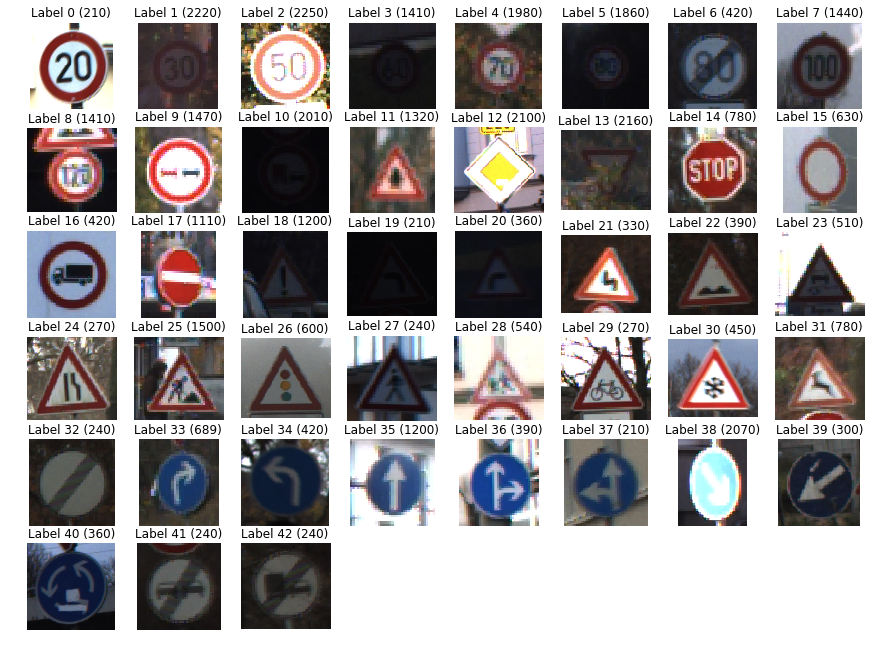

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
# Visualizations will be shown in the notebook.
%matplotlib inline
init_notebook_mode(connected=True)  

plotSamplesSummary(X_raw, y_raw, classes)
histogram(y_raw, 'class', 'count', 'Number of Samples per Class')



#### Explore more images in the sample data

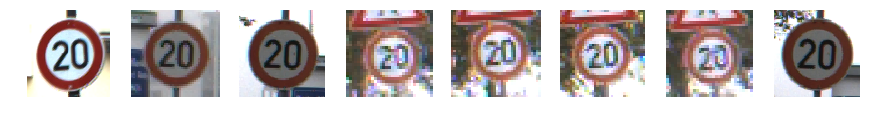

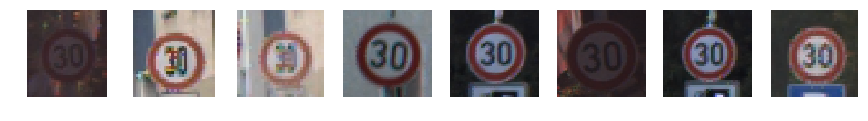

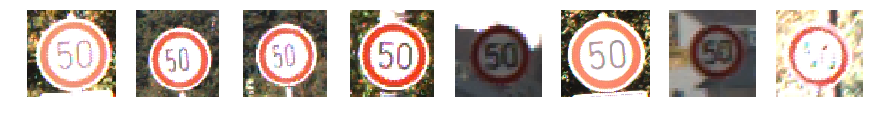

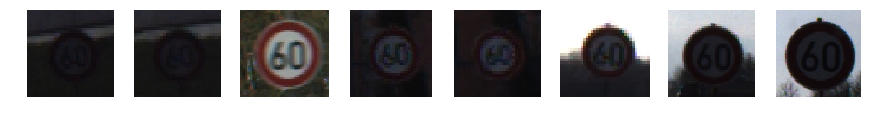

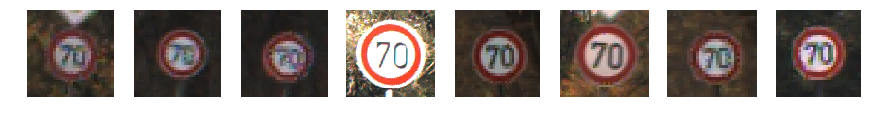

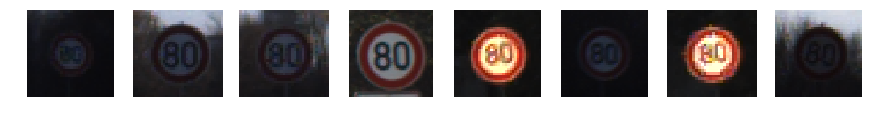

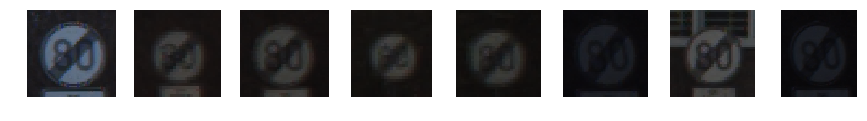

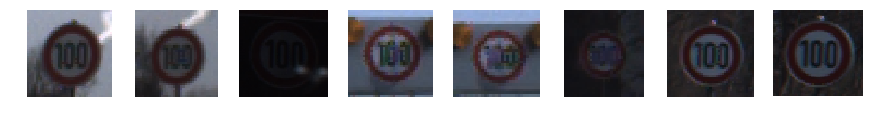

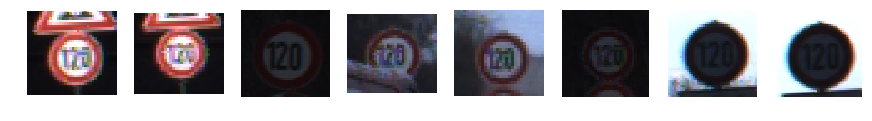

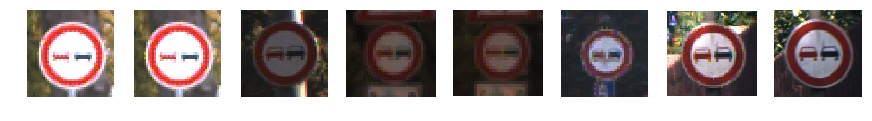

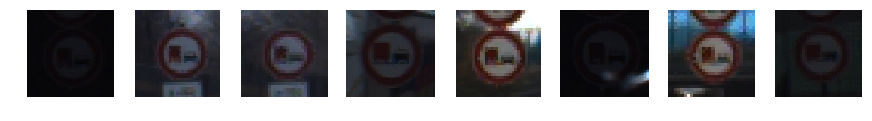

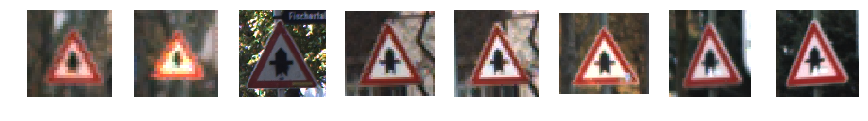

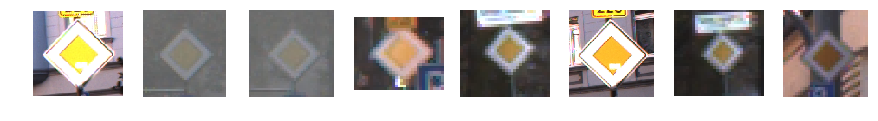

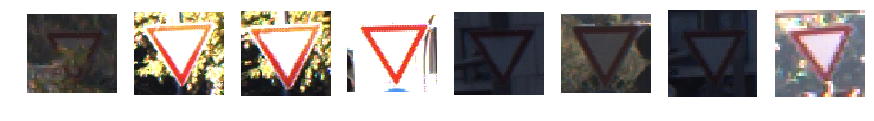

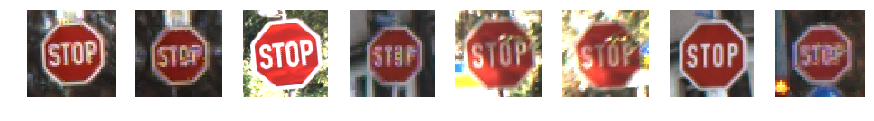

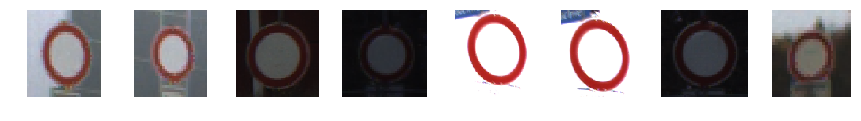

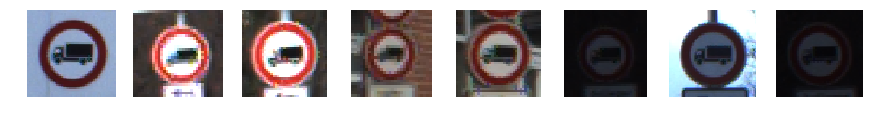

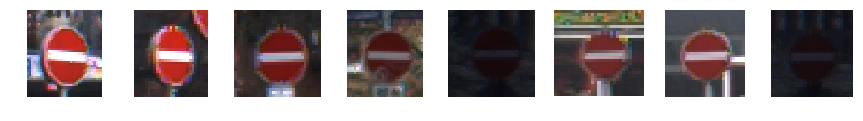

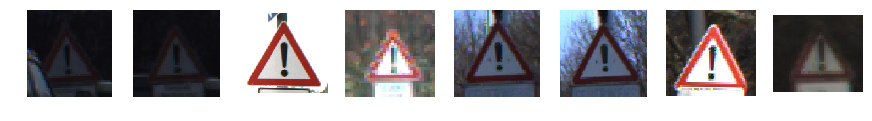

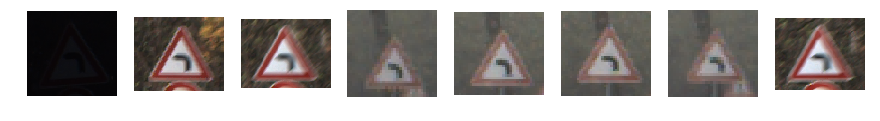

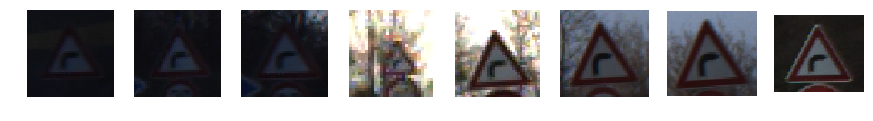

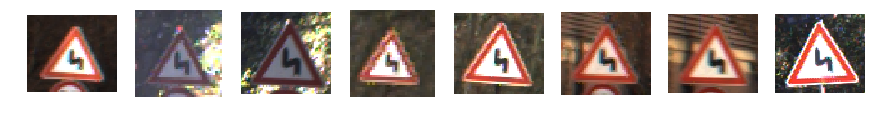

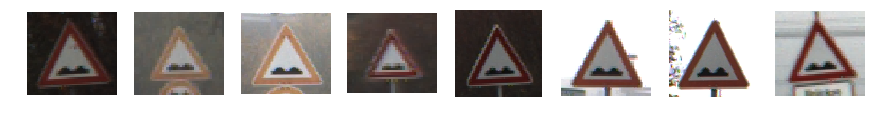

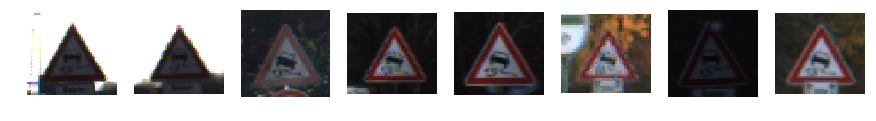

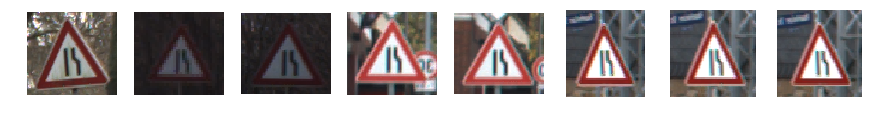

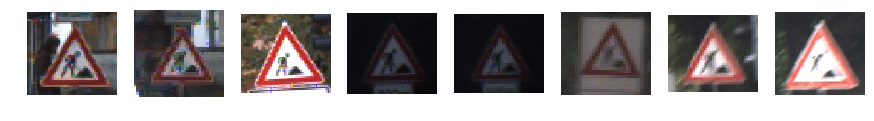

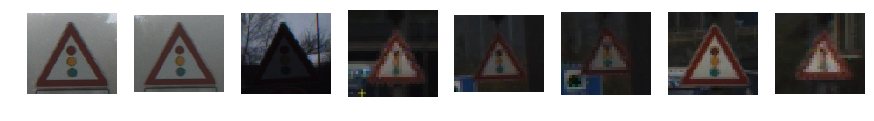

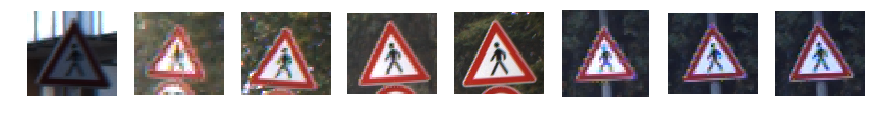

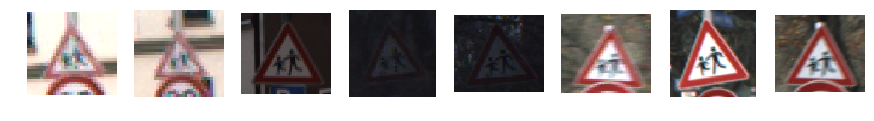

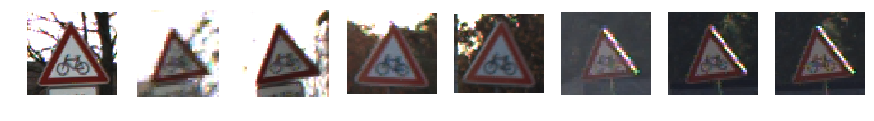

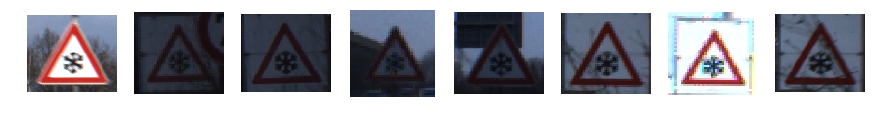

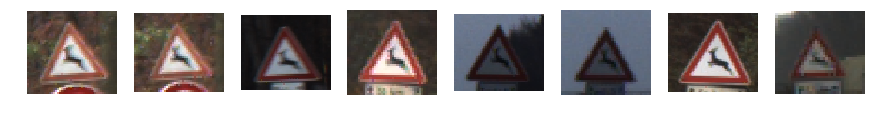

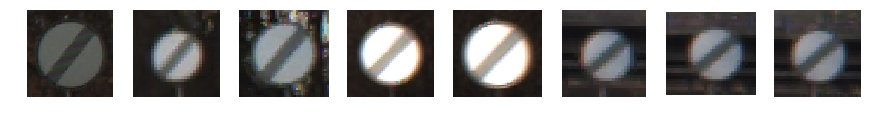

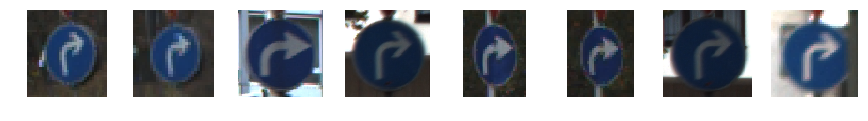

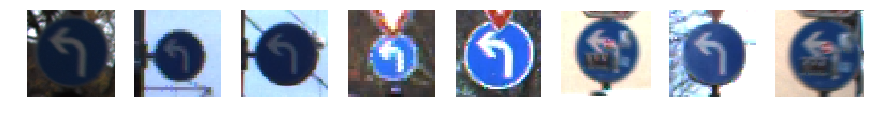

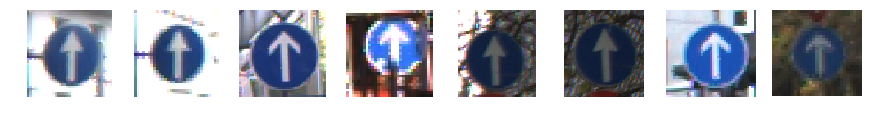

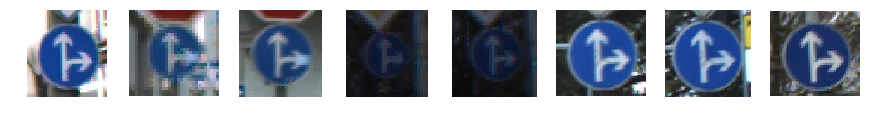

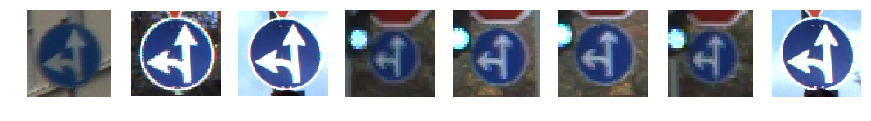

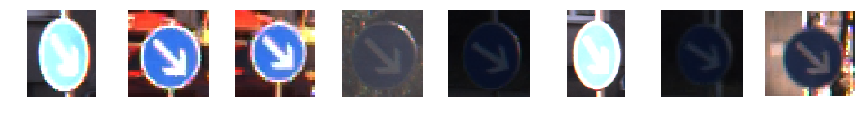

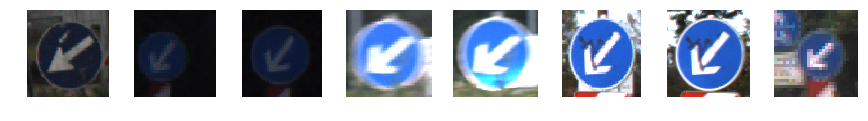

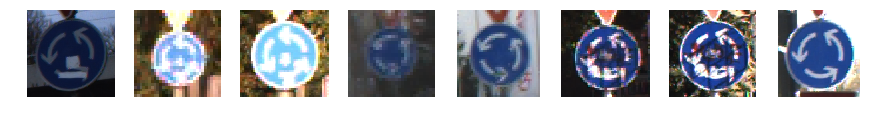

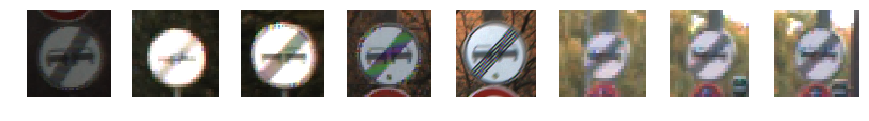

In [5]:
for label in classes:
    X_classes = getImageForClass(label)
    plotImage(X_classes[0:8])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
histogram([x.shape[0] for x in X_raw], 'width', 'count', 'Image sample width distribution')



In [7]:
histogram([x.shape[1] for x in X_raw], 'height', 'count', 'Image sample height distribution')


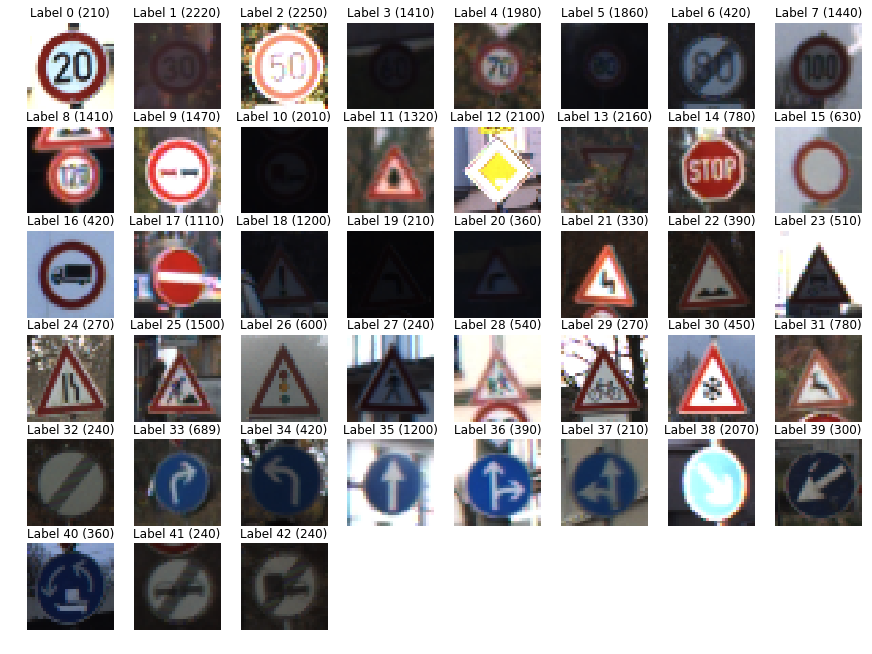

In [8]:
# CNN should work on same width x height size picture, here it is 32 x 32 x 3 
# we already resize it previously in X_norm, plot here

plotSamplesSummary(X_norm, y_norm, classes)



### Model Architecture

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
# we use similar network as describe in the classroom as a start point.
# it includes 2 convolution layer and 2 full connected layer and 1 output layer as show below.
# please note, here it is color image, so the inital input is 3 instead of 1.

mu = 0
sigma = 0.1

weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 18), mean=mu, stddev=sigma)),
    'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 18, 50), mean=mu, stddev=sigma)),
    'wd1': tf.Variable(tf.truncated_normal(shape=(5 * 5 * 50, 1000), mean=mu, stddev=sigma)),
    'wd2': tf.Variable(tf.truncated_normal(shape=(1000, 300), mean=mu, stddev=sigma)),
    'out': tf.Variable(tf.truncated_normal(shape=(300, N_CLASSES), mean=mu, stddev=sigma))}

biases = {
    'bc1': tf.Variable(tf.zeros([18])),
    'bc2': tf.Variable(tf.zeros([50])),
    'bd1': tf.Variable(tf.zeros([1000])),
    'bd2': tf.Variable(tf.zeros([300])),
    'out': tf.Variable(tf.zeros([N_CLASSES]))}


def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')


def full(x, W, b):
    x = tf.reshape(x, [-1, W.get_shape().as_list()[0]])
    x = tf.add(tf.matmul(x, W), b)
    return tf.nn.relu(x)


def LeNet(x):

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x18.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])

    #  Pooling. Input = 28x28x18. Output = 14x14x18.
    conv1 = maxpool2d(conv1, k=2)

    #  Layer 2: Convolutional. Output = 10x10x50.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])

    # Pooling. Input = 10x10x50. Output = 5x5x50.
    conv2 = maxpool2d(conv2, k=2)

    # Flatten. Input = 5x5x50. Output = 1000.
    fc1 = full(conv2, weights['wd1'], biases['bd1'])

    # Layer 3: Fully Connected. Input = 1000. Output = 300.
    fc2 = full(fc1, weights['wd2'], biases['bd2'])

    # Layer 5: Fully Connected. Input = 300. Output = N_CLASSES.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [10]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


def validationGroup(X_data, y_data):
    X_group = [[] for i in range(0, N_CLASSES)]
    y_group = [[] for i in range(0, N_CLASSES)]
    for i in range(0, len(y_data)):
        X_group[y_data[i]].append(X_data[i])
        y_group[y_data[i]].append(y_data[i])
    return X_group, y_group


def evaluatePerClass(X_data, y_data):
    accuracy = []
    X_group, y_group = validationGroup(X_data, y_data)
    for i in range(0, len(y_group)):
        accuracy.append(evaluate(X_group[i], y_group[i]))
    return accuracy

def plotArray(X):
    trace1 = go.Scatter(x=[i for i in range(0, len(X))], y=X, mode='lines+markers', name='linear')
    trace2 = go.Bar(x=[i for i in range(0, len(X))], y=X, name="bar")
    data = go.Data([trace1, trace2])
    py.iplot(data)

In [11]:
# Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, N_CLASSES)
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

EPOCHS = 10
BATCH_SIZE = 128

perEpochAccuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_validation, y_validation)
        perEpochAccuracy.append(validation_accuracy)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy is {:.3f}".format(validation_accuracy))
        print()

    perClassAccuracy = evaluatePerClass(X_validation, y_validation)
    saver.save(sess, './traffic_signs')
    print("Model saved")


plotArray(perClassAccuracy)

plotArray(perEpochAccuracy)


Training...

EPOCH 1 ...
Validation Accuracy is 0.933

EPOCH 2 ...
Validation Accuracy is 0.962

EPOCH 3 ...
Validation Accuracy is 0.976

EPOCH 4 ...
Validation Accuracy is 0.987

EPOCH 5 ...
Validation Accuracy is 0.988

EPOCH 6 ...
Validation Accuracy is 0.986

EPOCH 7 ...
Validation Accuracy is 0.990

EPOCH 8 ...
Validation Accuracy is 0.990

EPOCH 9 ...
Validation Accuracy is 0.992

EPOCH 10 ...
Validation Accuracy is 0.979

Model saved


---

### Second Try: Test with Larger Size of Image Samples 

In [12]:
# Use larger image set
import numpy as np
print("Average width is = {:.3f}".format(np.mean([x.shape[0] for x in X_raw])))
print("Average Height is = {:.3f}".format(np.mean([x.shape[1] for x in X_raw])))



Average width is = 50.329
Average Height is = 50.836


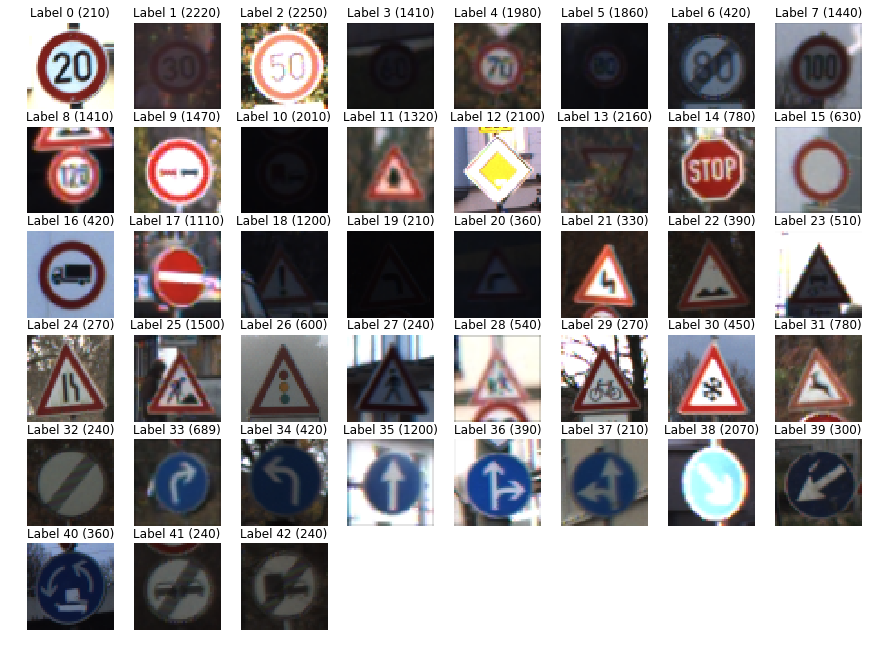

In [13]:
# so we resize to 48 x 48
X_norm = [skimage.transform.resize(image, (48, 48), mode='constant') for image in X_raw]
y_norm = y_raw
X_train, X_validation, y_train, y_validation = train_test_split(
    X_norm, y_norm, stratify=y_norm, test_size=9209, random_state=0)

plotSamplesSummary(X_norm, y_norm, classes)

In [36]:
# rerun the model again, use same filter size 5 x 5

weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 18), mean=mu, stddev=sigma)),
    'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 18, 50), mean=mu, stddev=sigma)),
    'wd1': tf.Variable(tf.truncated_normal(shape=(9 * 9 * 50, 1000), mean=mu, stddev=sigma)),
    'wd2': tf.Variable(tf.truncated_normal(shape=(1000, 300), mean=mu, stddev=sigma)),
    'out': tf.Variable(tf.truncated_normal(shape=(300, N_CLASSES), mean=mu, stddev=sigma))}

biases = {
    'bc1': tf.Variable(tf.zeros([18])),
    'bc2': tf.Variable(tf.zeros([50])),
    'bd1': tf.Variable(tf.zeros([1000])),
    'bd2': tf.Variable(tf.zeros([300])),
    'out': tf.Variable(tf.zeros([N_CLASSES]))}

EPOCHS = 10
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 48, 48, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, N_CLASSES)
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './traffic_signs_2')
    print("Model saved")



Training...

EPOCH 1 ...
Validation Accuracy = 0.945

EPOCH 2 ...
Validation Accuracy = 0.983

EPOCH 3 ...
Validation Accuracy = 0.989

EPOCH 4 ...
Validation Accuracy = 0.989

EPOCH 5 ...
Validation Accuracy = 0.985

EPOCH 6 ...
Validation Accuracy = 0.989

EPOCH 7 ...
Validation Accuracy = 0.990

EPOCH 8 ...
Validation Accuracy = 0.975

EPOCH 9 ...
Validation Accuracy = 0.990

EPOCH 10 ...
Validation Accuracy = 0.991

Model saved


It appears not significant different by using a larger image, and the time increased dramatically. Therefore we will reduce to 32 * 32 image size.

---

### Thrid Try: Add One Additional Full Connected Layer

In [ ]:
# so we resize to 32 x 32
X_norm = [skimage.transform.resize(image, (32, 32), mode='constant') for image in X_raw]
y_norm = y_raw
X_train, X_validation, y_train, y_validation = train_test_split(
    X_norm, y_norm, stratify=y_norm, test_size=9209, random_state=0)

In [39]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

mu = 0
sigma = 0.1

weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 18), mean=mu, stddev=sigma)),
    'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 18, 100), mean=mu, stddev=sigma)),
    'wd1': tf.Variable(tf.truncated_normal(shape=(5 * 5 * 100, 2000), mean=mu, stddev=sigma)),
    'wd2': tf.Variable(tf.truncated_normal(shape=(2000, 1000), mean=mu, stddev=sigma)),
    'wd3': tf.Variable(tf.truncated_normal(shape=(1000, 300), mean=mu, stddev=sigma)),
    'out': tf.Variable(tf.truncated_normal(shape=(300, N_CLASSES), mean=mu, stddev=sigma))}

biases = {
    'bc1': tf.Variable(tf.zeros([18])),
    'bc2': tf.Variable(tf.zeros([100])),
    'bd1': tf.Variable(tf.zeros([2000])),
    'bd2': tf.Variable(tf.zeros([1000])),
    'bd3': tf.Variable(tf.zeros([300])),
    'out': tf.Variable(tf.zeros([N_CLASSES]))}


def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')


def full(x, W, b):
    x = tf.reshape(x, [-1, W.get_shape().as_list()[0]])
    x = tf.add(tf.matmul(x, W), b)
    return tf.nn.relu(x)


def LeNet(x):

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x18.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])

    #  Pooling. Input = 28x28x18. Output = 14x14x18.
    conv1 = maxpool2d(conv1, k=2)

    #  Layer 2: Convolutional. Output = 10x10x100.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])

    # Pooling. Input = 10x10x100. Output = 5x5x100.
    conv2 = maxpool2d(conv2, k=2)

    # Flatten. Input = 5x5x100. Output = 2000.
    fc1 = full(conv2, weights['wd1'], biases['bd1'])

    # Layer 3: Fully Connected. Input = 2000. Output = 1000.
    fc2 = full(fc1, weights['wd2'], biases['bd2'])

    # Layer 4: Fully Connected. Input = 1000. Output = 300.
    fc3 = full(fc2, weights['wd3'], biases['bd3'])

    # Layer 5: Fully Connected. Input = 300. Output = N_CLASSES.
    logits = tf.add(tf.matmul(fc3, weights['out']), biases['out'])
    return logits


EPOCHS = 10
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, N_CLASSES)
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './traffic_signs_3')
    print("Model saved")



Training...

EPOCH 1 ...
Validation Accuracy = 0.963

EPOCH 2 ...
Validation Accuracy = 0.972

EPOCH 3 ...
Validation Accuracy = 0.983

EPOCH 4 ...
Validation Accuracy = 0.986

EPOCH 5 ...
Validation Accuracy = 0.991

EPOCH 6 ...
Validation Accuracy = 0.988

EPOCH 7 ...
Validation Accuracy = 0.992

EPOCH 8 ...
Validation Accuracy = 0.988

EPOCH 9 ...
Validation Accuracy = 0.973

EPOCH 10 ...
Validation Accuracy = 0.983

Model saved


This suggest we should reduce the learning rate. Change rate to 0.0001 and rerun the test.

In [41]:
rate = 0.0001
EPOCHS = 30

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './traffic_signs_3_1')
    print("Model saved")



Training...

EPOCH 1 ...
Validation Accuracy = 0.773

EPOCH 2 ...
Validation Accuracy = 0.906

EPOCH 3 ...
Validation Accuracy = 0.934

EPOCH 4 ...
Validation Accuracy = 0.945

EPOCH 5 ...
Validation Accuracy = 0.956

EPOCH 6 ...
Validation Accuracy = 0.966

EPOCH 7 ...
Validation Accuracy = 0.971

EPOCH 8 ...
Validation Accuracy = 0.976

EPOCH 9 ...
Validation Accuracy = 0.969

EPOCH 10 ...
Validation Accuracy = 0.978

EPOCH 11 ...
Validation Accuracy = 0.979

EPOCH 12 ...
Validation Accuracy = 0.982

EPOCH 13 ...
Validation Accuracy = 0.983

EPOCH 14 ...
Validation Accuracy = 0.989

EPOCH 15 ...
Validation Accuracy = 0.989

EPOCH 16 ...
Validation Accuracy = 0.988

EPOCH 17 ...
Validation Accuracy = 0.979

EPOCH 18 ...
Validation Accuracy = 0.981

EPOCH 19 ...
Validation Accuracy = 0.985

EPOCH 20 ...
Validation Accuracy = 0.990

EPOCH 21 ...
Validation Accuracy = 0.991

EPOCH 22 ...
Validation Accuracy = 0.991

EPOCH 23 ...
Validation Accuracy = 0.991

EPOCH 24 ...
Validation Accura

In [49]:
def plotArray(X):
    trace1 = go.Scatter(x=[i for i in range(0, len(X))], y=X, mode='lines+markers', name='linear')
    trace2 = go.Bar(x=[i for i in range(0, len(X))], y=X, name="bar")
    data = go.Data([trace1, trace2])
    py.iplot(data)
plotArray([0.773, 0.906, 0.934, 0.945, 0.956, 0.966, 0.971, 0.976, 0.969, 0.978, 0.979, 0.982, 0.983, 0.989, 0.989,
           0.988, 0.979, 0.981, 0.985, 0.990, 0.991, 0.991, 0.991, 0.990, 0.991, 0.991, 0.991, 0.991, 0.991, 0.991])

---

### Fouth Try: Use a Different Optimizer

In [43]:
mu = 0
sigma = 0.1

weights = {
    'wc1': tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 18), mean=mu, stddev=sigma)),
    'wc2': tf.Variable(tf.truncated_normal(shape=(5, 5, 18, 50), mean=mu, stddev=sigma)),
    'wd1': tf.Variable(tf.truncated_normal(shape=(5 * 5 * 50, 1000), mean=mu, stddev=sigma)),
    'wd2': tf.Variable(tf.truncated_normal(shape=(1000, 300), mean=mu, stddev=sigma)),
    'out': tf.Variable(tf.truncated_normal(shape=(300, N_CLASSES), mean=mu, stddev=sigma))}

biases = {
    'bc1': tf.Variable(tf.zeros([18])),
    'bc2': tf.Variable(tf.zeros([50])),
    'bd1': tf.Variable(tf.zeros([1000])),
    'bd2': tf.Variable(tf.zeros([300])),
    'out': tf.Variable(tf.zeros([N_CLASSES]))}


def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')


def full(x, W, b):
    x = tf.reshape(x, [-1, W.get_shape().as_list()[0]])
    x = tf.add(tf.matmul(x, W), b)
    return tf.nn.relu(x)


def LeNet(x):

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x18.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])

    #  Pooling. Input = 28x28x18. Output = 14x14x18.
    conv1 = maxpool2d(conv1, k=2)

    #  Layer 2: Convolutional. Output = 10x10x50.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])

    # Pooling. Input = 10x10x50. Output = 5x5x50.
    conv2 = maxpool2d(conv2, k=2)

    # Flatten. Input = 5x5x50. Output = 1000.
    fc1 = full(conv2, weights['wd1'], biases['bd1'])

    # Layer 3: Fully Connected. Input = 1000. Output = 300.
    fc2 = full(fc1, weights['wd2'], biases['bd2'])

    # Layer 5: Fully Connected. Input = 300. Output = N_CLASSES.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return logits

EPOCHS = 10
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, N_CLASSES)
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdagradOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './traffic_signs')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.284

EPOCH 2 ...
Validation Accuracy = 0.429

EPOCH 3 ...
Validation Accuracy = 0.498

EPOCH 4 ...
Validation Accuracy = 0.550

EPOCH 5 ...
Validation Accuracy = 0.589

EPOCH 6 ...
Validation Accuracy = 0.617

EPOCH 7 ...
Validation Accuracy = 0.666

EPOCH 8 ...
Validation Accuracy = 0.695

EPOCH 9 ...
Validation Accuracy = 0.712

EPOCH 10 ...
Validation Accuracy = 0.740

Model saved


Adagrad is slower than Adam in our case.

---
### Fifth Try: Augument Input Image

In [67]:
# some classes are very few images, we will augument those classes that has count less than 500
weakLabels = [label for label in classes if y_raw.count(label) < 500]


In [77]:
def sometimes(aug):
    # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
    # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
    return iaa.Sometimes(0.5, aug)


def createAugumentor():
    # Define our sequence of augmentation steps that will be applied to every image
    # All augmenters with per_channel=0.5 will sample one value _per image_
    # in 50% of all cases. In all other cases they will sample new values
    # _per channel_.
    seq = iaa.Sequential(
        [
            # crop images by -5% to 10% of their height/width
            sometimes(iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode=ia.ALL,
                pad_cval=(0, 255)
            )),
            sometimes(iaa.Affine(
                # scale images to 80-120% of their size, individually per axis
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                # translate by -20 to +20 percent (per axis)
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-45, 45),  # rotate by -45 to +45 degrees
                shear=(-16, 16),  # shear by -16 to +16 degrees
                order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
                # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                mode=ia.ALL
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                       [
                # convert images into their superpixel representation
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))),
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
                    # blur image using local means with kernel sizes between 2 and 7
                    iaa.AverageBlur(k=(2, 7)),
                    # blur image using local medians with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255),
                                          per_channel=0.5),  # add gaussian noise to images
                iaa.OneOf([
                    # randomly remove up to 10% of the pixels
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True),  # invert color channels
                # change brightness of images (by -10 to 10 of original value)
                iaa.Add((-10, 10), per_channel=0.5),
                iaa.AddToHueAndSaturation((-20, 20)),  # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                # improve or worsen the contrast
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
                iaa.Grayscale(alpha=(0.0, 1.0)),
                # move pixels locally around (with random strengths)
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),
                # sometimes move parts of the image around
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq


def augumentImages(labels):
    augimages = []
    auglabels = []
    augmentor = createAugumentor()
    for label in labels:
        X_classes = getImageForClass(label)
        augimages_raw = augmentor.augment_images(X_classes)
        for image in augimages_raw: 
            augimages.append(skimage.transform.resize(image, (32, 32), mode='constant'))
            auglabels.append(label)
    return augimages, auglabels


augImages, augLabels = augumentImages(weakLabels)


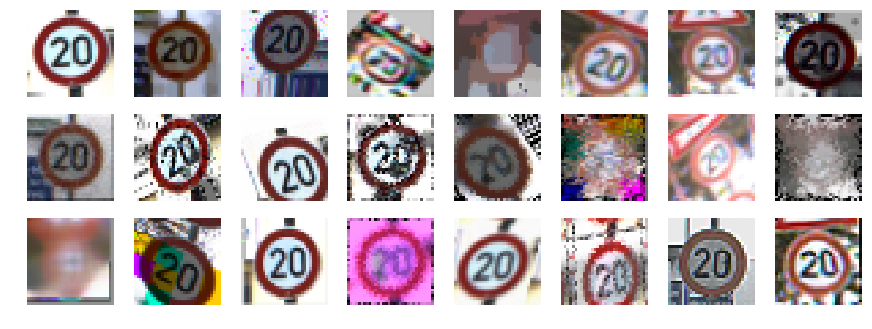

In [78]:

plotImage(augImages[0:24])



In [79]:
print("Augmented images: {}".format(len(augImages)))

Augmented images: 5730


In [80]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_norm, y_norm, stratify=y_norm, test_size=9209, random_state=0)
X_train.extend(augImages)
y_train.extend(augLabels)

perEpochAccuracy = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_validation, y_validation)
        perEpochAccuracy.append(validation_accuracy)
        print("EPOCH {} ...".format(i + 1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    perClassAccuracy = evaluatePerClass(X_validation, y_validation)
    saver.save(sess, './traffic_signs')
    print("Model saved")



plotArray(perClassAccuracy)

plotArray(perEpochAccuracy)



Training...

EPOCH 1 ...
Validation Accuracy = 0.937

EPOCH 2 ...
Validation Accuracy = 0.975

EPOCH 3 ...
Validation Accuracy = 0.977

EPOCH 4 ...
Validation Accuracy = 0.981

EPOCH 5 ...
Validation Accuracy = 0.987

EPOCH 6 ...
Validation Accuracy = 0.988

EPOCH 7 ...
Validation Accuracy = 0.983

EPOCH 8 ...
Validation Accuracy = 0.989

EPOCH 9 ...
Validation Accuracy = 0.983

EPOCH 10 ...
Validation Accuracy = 0.988

Model saved


It reduce validation accuracy STD of all classes, but looks not improving a lot in MEAN.

In [15]:
# first normalize
X_test = [skimage.transform.resize(image, (32, 32), mode='constant') for image in X_test]

In [27]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.918


In [25]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(test_accuracy))

Train Accuracy = 0.991


In [26]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_validation, y_validation)
    print("Validation Accuracy = {:.3f}".format(test_accuracy))

Train Accuracy = 0.979


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

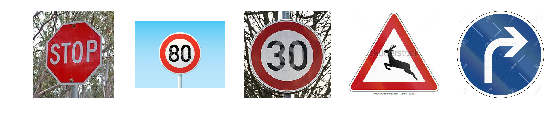

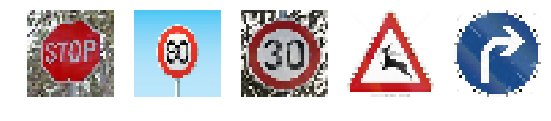

[14  5  1 31 33]


In [17]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

def load_new_data():
    csv_file = os.path.join(NEW_IMAGE_DIR, 'manifest.csv')
    csv = pd.read_csv(csv_file, sep=';')
    labels = csv['ClassId'].values
    files = csv['Filename'].values
    images = []
    for file in files:
        f = os.path.join(NEW_IMAGE_DIR, file)
        images.append(skimage.data.imread(f))
    return images, labels


X_new, y_new = load_new_data()

plotImage(X_new)

X_new_norm = [skimage.transform.resize(image, (32, 32), mode='constant') for image in X_new]

plotImage(X_new_norm)

print(y_new)



### Predict the Sign Type for Each Image

In [19]:

### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prediction=tf.argmax(logits,1)
    best = sess.run([prediction],feed_dict={x:X_new_norm})
    print(best)





[array([14,  5,  1, 31, 33])]


### Analyze Performance

In [20]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./traffic_signs.meta')
    saver.restore(sess, "./traffic_signs")
    test_accuracy = evaluate(X_new_norm, y_new)
    print("New data Test Accuracy = {:.3f}".format(test_accuracy))



New data Test Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [21]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./traffic_signs.meta')
    saver.restore(sess, "./traffic_signs")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: X_new_norm})
    my_top_k = sess.run(top_k, feed_dict={x: X_new_norm})
    print(my_top_k)
    

    

TopKV2(values=array([[  1.00000000e+00,   5.76974232e-13,   2.17618566e-13,
          8.68988312e-14,   2.45220697e-14],
       [  9.92458224e-01,   5.94804296e-03,   9.76459007e-04,
          4.93374187e-04,   4.36481096e-05],
       [  1.00000000e+00,   3.97764275e-08,   8.02838563e-14,
          1.51854949e-14,   1.17160853e-17],
       [  9.99554217e-01,   4.26491664e-04,   1.93246815e-05,
          1.41658990e-10,   4.47433757e-11],
       [  1.00000000e+00,   3.52916156e-12,   2.39754207e-13,
          1.30219891e-13,   1.24684985e-13]], dtype=float32), indices=array([[14,  1, 25, 13, 29],
       [ 5,  3, 13,  0,  1],
       [ 1,  0,  2,  5, 29],
       [31,  1, 21, 11,  5],
       [33, 11, 30,  1, 13]], dtype=int32))


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [22]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [33]:
print(len(X_new_norm))

5


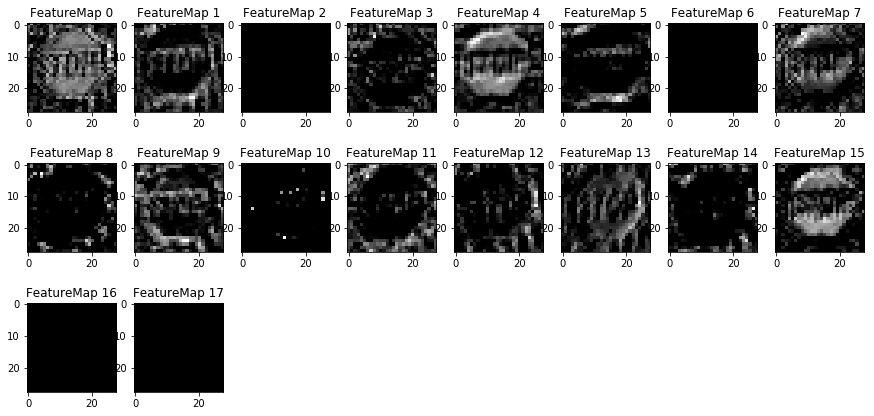

In [36]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./traffic_signs.meta')
    saver.restore(sess, "./traffic_signs")
    outputFeatureMap([X_new_norm[0]], conv2d(x, weights['wc1'], biases['bc1']))